## Introduction

The following analysis has the purpose of studying the characteristics of the customers of Blackwell Electronics with the objective of gaining further comprehension about both the buyinthe revenue.g patterns of the clients and about the customers themselves. This information can be used to focus the advertisement campaigns of the company in better ways in order to increase the revenue.<br>
For this purpose various techniques of data analysis will be used, starting with an Exploratory Data Analysis of the data set, using graphics and statistical measurements to explain certain behaviours in the data. After that, machine learning algorithms will be used to obtain models that predict certain characteristichs. The main questions that will be studied in the analysis are the following:<br>
<ul>
<li>Do customers in different regions spend more per transaction?</li>
<li>Which regions spend the most/least?</li>
<li>Is there a relationship between number of items purchased and amount spent?</li>
<li>Are there differences in the age of customers between regions?</li>
<li>If so, can we predict the age of a customer in a region based on other demographic data?</li>
<li>Is there any correlation between the age of a customer and if the transaction was made online or in the store?</li>
<li>Do other factors correlate to an online or in-store transaction?</li>
</ul>
Additionally further insights about the data will be studied and explained to provide a wider understanding about the customers.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

## Reading Data Set with Pandas

In [2]:
data = pd.read_csv('Demographic_Data.csv')
data.head()
#Importing data and doing an initial visualization

,in-store,age,items,amount,region
0,0,37,4,281.03,2
1,0,35,2,219.51,2
2,1,45,3,1525.70,4
3,1,46,3,715.25,3
4,1,33,4,1937.50,1


The data used in this analysis has been provided by Blackwell Electronics, and contains information about the purchases themselves and about the customers that made them. As it can be seen it includes the price, the number of items ordered, if the purchase was done in a physical store or online, the age of the customer and where it was done.<br>
Most of the variables are numeric, with the exception of 'in-store' and 'region'. These are both cathegorical variables which have been encoded numerically. The variable 'in-store' has values of 0 (online purchase) and 1 (physical store), while 'region' can have the values 1 (North), 2 (South), 3 (East) and 4 (West).

## Analysis


## Pre-Processing

In [3]:
data.describe()

,in-store,age,items,amount,region
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.500000,45.757925,4.504975,835.919670,2.675000
std,0.500003,15.715679,2.061238,721.273736,1.126672
min,0.000000,18.000000,1.000000,5.004700,1.000000
25%,0.000000,33.000000,3.000000,285.140000,2.000000
50%,0.500000,45.000000,4.000000,582.315000,3.000000
75%,1.000000,56.000000,6.000000,1233.700000,4.000000
max,1.000000,85.000000,8.000000,3000.000000,4.000000


Initially some sense of the data is obtained.

In [4]:
#basic info about the data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   in-store  80000 non-null  int64  
 1   age       80000 non-null  int64  
 2   items     80000 non-null  int64  
 3   amount    80000 non-null  float64
 4   region    80000 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 3.1 MB


The data types of all the data is obtained. Note that although 'in-store' and 'region' are numeric times, they are actually cathegorical variables.

In [5]:
#Duplicated values
print("Duplicate values:\t",data.duplicated().sum())

Duplicate values:	 21


The data is checked for duplicates. Since the number of duplicated data is small relative to the sample size, and given there is no way to check if the data is truly duplicated or simply different orders with the same characteristics, this records will be kept.

In [6]:
#Null values
print("Null values:\n",data.isnull().sum())

Null values:
 in-store    0
age         0
items       0
amount      0
region      0
dtype: int64


The data contains is searched for null values but there are none.

In [7]:
#Invalid values
print("Invalid 'in-store' values:\t",((data['in-store'] != 0) & (data['in-store'] != 1)).sum())
print("Invalid 'age' values:\t\t",((data['age'] <= 0) | (data['age'] > 200)).sum())
print("Invalid 'items' values:\t\t",((data['items'] <= 0)).sum())
print("Invalid 'amount' values:\t",((data['amount'] <= 0)).sum())
print("Invalid 'region' values:\t",((data['region'] != 1) & (data['region'] != 2) & (data['region'] != 3) & (data['region'] != 4)).sum())

Invalid 'in-store' values:	 0
Invalid 'age' values:		 0
Invalid 'items' values:		 0
Invalid 'amount' values:	 0
Invalid 'region' values:	 0


The data is checked for invalid values (negative or null ages, prices or quantities and invalid values of cathegorical variables), but it does not contain any.

In [8]:
#Outliers
## 'age' outliers
iq_age = data.quantile(.75)['age'] - data.quantile(.25)['age']
age_out = data.loc[(((data['age'] < data.quantile(.25)['age'] - iq_age*1.5) | (data['age'] > data.quantile(.75)['age'] + iq_age*1.5)) == True)]
print("Outliers in 'age':\t",age_out.size/5)
## 'items' outliers
iq_items = data.quantile(.75)['items'] - data.quantile(.25)['items']
items_out = data.loc[(((data['items'] < data.quantile(.25)['items'] - iq_items*1.5) | (data['items'] > data.quantile(.75)['items'] + iq_items*1.5)) == True)]
print("Outliers in 'items':\t",items_out.size/5)
## 'amount' outliers
iq_amount = data.quantile(.75)['amount'] - data.quantile(.25)['amount']
amount_out = data.loc[(((data['amount'] < data.quantile(.25)['amount'] - iq_amount*1.5) | (data['amount'] > data.quantile(.75)['amount'] + iq_amount*1.5)) == True)]
print("Outliers in 'amount':\t",amount_out['amount'].count())

Outliers in 'age':	 0.0
Outliers in 'items':	 0.0
Outliers in 'amount':	 2318


The only quantity that presents outliers is the amount payed in the order. Still given that in an electronic store the prices can range from thousands of dollars (a computer) to very small prices (a mouse pad), directly excluding them would leave an important part of the data out of the analysis. Still they will be kept stored in case that some future analysis could benefit from excluding these values.

In [9]:
#Number of decimals in amount
print("Values of 'amount' with more than two decimals:\t",data.loc[((data.amount*100).apply(np.floor))/100 != data.amount]['amount'].size)

Values of 'amount' with more than two decimals:	 9012


Normally currency values only contain two decimal ciphers. The cause of this abnormal values is most likely related with the VAT and the way the values are stored, probably before applying the tax. Since this additional impact represent an infimum difference compared with the magnitude of the values, they will not be rounded off, as their impact in the analysis will be negligible.

In [10]:
#One-hot encoding the region variable
data = data.join((data['region'] == 1).apply(int).rename('North'))
data = data.join((data['region'] == 2).apply(int).rename('South'))
data = data.join((data['region'] == 3).apply(int).rename('East'))
data = data.join((data['region'] == 4).apply(int).rename('West'))

Although the integer encoding used in the region variable can be useful for some parts of the analysis, later on when trying to create models, many machine learning algorithms work better with one-hot encoded variables so re-encoding the variable may be useful.

## Exploratory Data Analysis

### Regional analysis

The main purpose of this section is finding the answer of the following questions:<br>
<ul>
<li>Do customers in different regions spend more per transaction?</li>
<li>Which regions spend the most/least?</li>
</ul>
To address the first question, the distribution of the amount spent in each transaction will be analyzed for each region.

In [11]:
#Check the amount of orders per region
data.groupby('region').size()

region
1    16000
2    20000
3    18000
4    26000
dtype: int64

[]

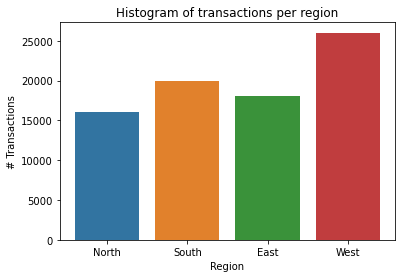

In [12]:
#Plot the number of orders per region
plot = sns.countplot(x = "region",data=data)
plot.set_xticklabels(['North','South','East','West'])
plot.set_title('Histogram of transactions per region')
plot.set_ylabel('# Transactions')
plot.set_xlabel('Region')
plot.plot()

<i>Figure 1. Histogram showing the amount of transactions in each region.</i>

It is noticeable that the West region has an higher amount of orders. Now the distribution of the amount spent is checked.

In [13]:
#Get number of transactions in each region
data.groupby('region').mean()['amount']

region
1     745.161491
2     252.109196
3     917.969637
4    1284.052012
Name: amount, dtype: float64

The means of the regions show that indeed there are differences in the amount per transaction spent in each region. Notice for example that region 2 (South) has the lowest mean while the previous graphic showed it is the recond with the second highest number of transactions. However, a more in depth analysis of the amount distribution would be helpful to get more precise conclussions.

[]

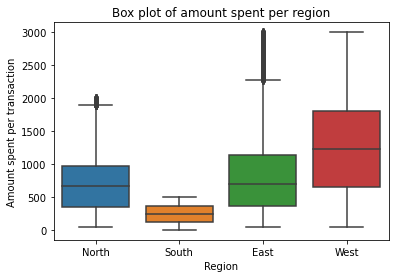

In [14]:
#Plot a box plot of the amount spent in each region
plot = sns.boxplot(x='region', y='amount', data = data)
plot.set_xticklabels(['North','South','East','West'])
plot.set_title('Box plot of amount spent per region')
plot.set_ylabel('Amount spent per transaction')
plot.set_xlabel('Region')
plot.plot()

<i>Figure 2. Box plot showing the distribution of the amount spent in transactions at each region.</i>

This graphic shows that there is a high amount of outliers in the East region and some of them in the Northern one. Also, the data in the West region is very distributed, so further analysis is required to draw reliable conclusions about these regions. Still, in the case of the Southern region the data is very concentrated around small values, so for now it can be assumed that this region spends less per transaction that the rest of them.

Text(0, 0.5, '# Transactions')

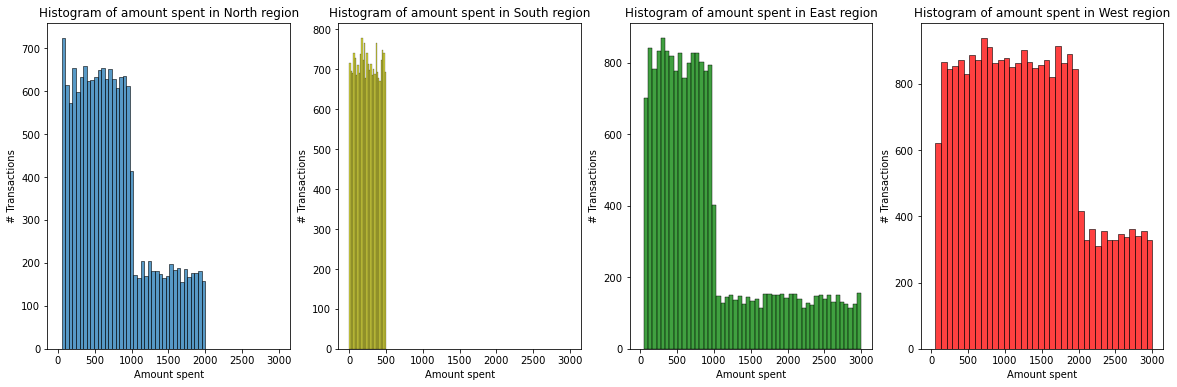

In [15]:
#Plot histograms of amount spent per transaction in each region
fig , axes = plt.subplots(1,4,figsize = (20,6), sharex=True)
sns.histplot(x="amount",data=data.groupby('region').get_group(1),ax=axes[0])
axes[0].title.set_text("Histogram of amount spent in North region")
axes[0].set_xlabel('Amount spent')
axes[0].set_ylabel('# Transactions')
sns.histplot(x="amount",data=data.groupby('region').get_group(2),ax=axes[1], color = 'y')
axes[1].title.set_text("Histogram of amount spent in South region")
axes[1].set_xlabel('Amount spent')
axes[1].set_ylabel('# Transactions')
sns.histplot(x="amount",data=data.groupby('region').get_group(3),ax=axes[2], color = 'g')
axes[2].title.set_text("Histogram of amount spent in East region")
axes[2].set_xlabel('Amount spent')
axes[2].set_ylabel('# Transactions')
sns.histplot(x="amount",data=data.groupby('region').get_group(4),ax=axes[3], color = 'r')
axes[3].title.set_text("Histogram of amount spent in West region")
axes[3].set_xlabel('Amount spent')
axes[3].set_ylabel('# Transactions')

<i>Figures 3-6. Histograms showing the distribution of the amount spent in transactions in each region.</i>

As it can be seen in the graphs, the South region spents the least per order in general, and all of its transactions are of small cost. In contrast, the West region spents the same or more in almost all of the price ranges (with the exception of the cheapest section for which there are more transactions in other regions). The North and East regions show similar buying patterns for the lower and intermediate price ranges, although there are transactions of high prices in East while there are none in the North.


<b>Do customers in different regions spend more per transaction?</b><br>
Yes, the South region spends the least per transaction while the West region spends the most. The North and East regions spend intermediately, with the East being ahead due to having high amount transactions. The main factor positioning the West as the main spender is the high number of intermediate priced transactions (1000-2000) in the region, whereas other regions have few or no transaction in that range. Improving transactions of that price range in other regions would cause a high impact in the total spending.

Answering the second question is more complex beacuse there are various answers to it. It has already been determined that in average, the West region spends the most and the South spends the least. However, analysing the total amount spent per region could be another way of answering the question and also gives important information.

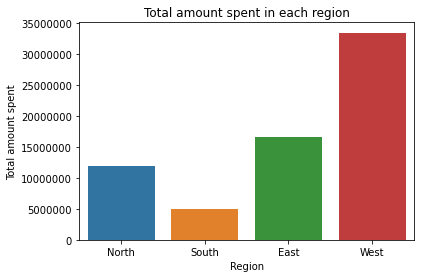

In [16]:
#Plot total amount spent in each region
plot = sns.barplot(x = 'region', y = 'amount',data = data.groupby('region').sum().reset_index())
plot.set_xticklabels(['North','South','East','West'])
plot.set_title("Total amount spent in each region")
plot.set_xlabel('Region')
plot.set_ylabel('Total amount spent')
plot.ticklabel_format(style='plain', axis='y')

<i>Figure 7. Total amount spent in each region</i>

<b>Which regions spend the most/least?</b><br>
After analyzing the total amount spent in each region, the conclusions obtained are the same as with the amount per transaction: again, the West spent the most, followed by the East and the North which spend signifcantly less. The South region is again the one spending the least.

Apart of answering this questions, analyzing how the purchases are done in each region could yield relevant information:

[]

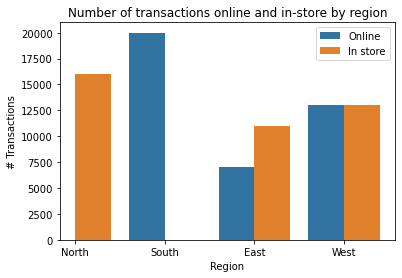

In [17]:
#Plot number of transactions online and in-store at each region
plot = sns.countplot(data = data, x = 'region', hue = 'in-store')
plot.set_xticklabels(['North','South','East','West'])
plot.legend(['Online','In store'])
plot.set_xlabel('Region')
plot.set_ylabel('# Transactions')
plot.set_title('Number of transactions online and in-store by region')
plot.plot()

<i>Figure 8. Bar plot showing the number of transactions online and in physical stores in each region.</i>

It is noticeable that the North region has no online transactions while the South has no transactions in physical stores. A possible explanation could be the South region having no stores and the online store being unavailable in the North. Opening this possibilities for these regions could be a way of increasing the profits generated there.

### Item quantity analysis

To answer the question about the possible relation between the number of items and the amount spent, an initial assumption will be done and the analysis will be centerend about confirming or disproving it. In this case, assuming that there exists some relationship between the number of items and the amount spent in an order makes sense, since one could think that buying more products would mean spending more money.<br>
Initially, the distribution of the amount spent is checked:

Text(-2.700000000000003, 0.5, '# Transactions')

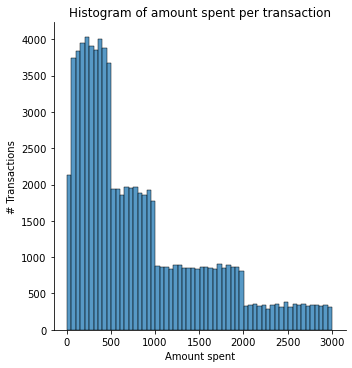

In [18]:
#Plot histogram of amount spent
plot = sns.displot(x='amount',data=data,binwidth = 50)
plot.axes[0][0].set_title('Histogram of amount spent per transaction')
plot.axes[0][0].set_xlabel('Amount spent')
plot.axes[0][0].set_ylabel('# Transactions')

<i>Figure 9. Histogram showing the distribution of the amount spent in each transaction.</i>

The frequency of the transaction decreases as the amount spent decreases. Some amount blocks can be appreciated and could be used in further analysis.

Now, if the initial assumption of a relationship between the number of items and the amount spent is true, then it could be expected that the number of bought items would follow a similar distribution.

Text(-9.075000000000003, 0.5, '# Transactions')

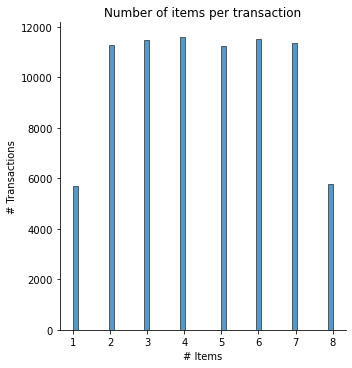

In [19]:
#Plot histogram of number of items per transaction
plot = sns.displot(x='items',data=data)
plot.axes[0][0].set_title('Number of items per transaction')
plot.axes[0][0].set_xlabel('# Items')
plot.axes[0][0].set_ylabel('# Transactions')

<i>Figure 10. Histogram showing the distribution of the number of items in each transaction.</i>

However, the distribution of the number of bought items is a lot different to that of the spent amount, which casts doubts on the initial hypothesis. To definitely confirm it, the distribution of the amount spent for each number of items can be analysed.

Text(0, 0.5, 'Amount spent')

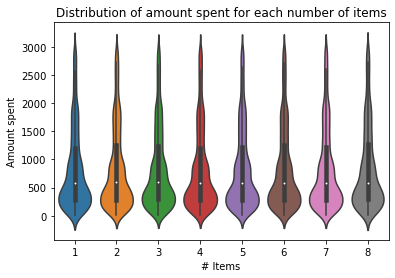

In [20]:
#Plot violin plots of amount spent for each number of items
plot = sns.violinplot(x="items", y="amount",kind = 'violin',data=data,size = (10,6))
plot.set_title('Distribution of amount spent for each number of items')
plot.set_xlabel('# Items')
plot.set_ylabel('Amount spent')

<i>Figure 11. Violin plot showing the distribution of the amount spent in each transaction for each number of items.</i>

In the above graphs it can be seen that for any number of items the amount spent follows almost the exact same distribution, so it can be safely concluded that there is no relationship between the number of items and the amount spent per transaction. To check it mathematically, the Pearson correlation coefficient can be calculated.

In [21]:
#Calculate correlation coefficient
print("The correlation between the number of items and the amount spent is ",data.corr()['items']['amount'])

The correlation between the number of items and the amount spent is  0.0003670028707839606


The correlation is almost 0, which fits with the conclussion of the two magnitudes not being related.

A possible explanation for this behaviour could be that orders with higher number of items include products of smaller price.

In [22]:
#Add average price per item to the dataset
avg_per_item=data['amount']/data['items']
avg_per_item = avg_per_item.rename("average")
data = data.join(avg_per_item)
data.head()

,in-store,age,items,amount,region,North,South,East,West,average
0,0,37,4,281.03,2,0,1,0,0,70.257500
1,0,35,2,219.51,2,0,1,0,0,109.755000
2,1,45,3,1525.70,4,0,0,0,1,508.566667
3,1,46,3,715.25,3,0,0,1,0,238.416667
4,1,33,4,1937.50,1,1,0,0,0,484.375000


Text(0, 0.5, 'Average price of items')

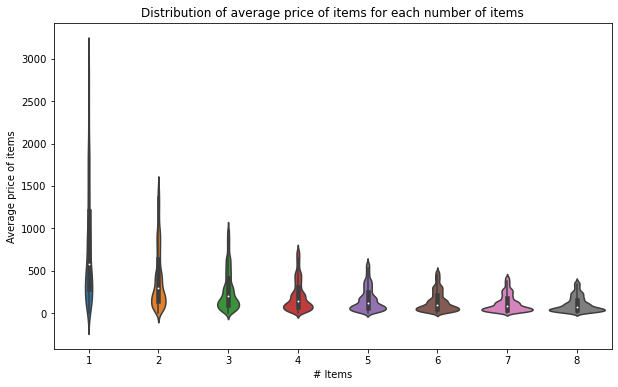

In [23]:
#Plot violin plot of average price per item for each number of items 
fig , axes = plt.subplots(1,1,figsize = (10,6), sharex=True)
sns.violinplot(x="items", y="average",kind = 'violin',data=data,ax = axes)
axes.set_title("Distribution of average price of items for each number of items")
axes.set_xlabel('# Items')
axes.set_ylabel('Average price of items')

<i>Figure 12. Violin plot showing the distribution of the average price of items for each number of items.</i>

The graphic shows that indeed, orders with a higher number of items have amounts more concentrated around low prices while orders with less items have more variated values. This could be explained with the fact that electronic stores sell a big range of products, from high priced devices to cheaper products like accesories. Orders with many items could come from accesories sales while transactions with fewer products would refer to orders of products of higher value.

<b>Is there a relationship between the number of items purchased and amount spent?</b><br>
No, there is no relationship between the number of items and the amount spent per transaction and for any number of items, the amount spent follows similar distributions. This is highly likely due to orders with more items being of products of less value.

### Age analysis

The last questions are all related to the age of the customers and its correlation with other factors, so an analysis of this factors will be performed to find insights about the data. The pursued information is the following:
<ul>
    <li>Differences of age between regions</li>
    <li>Relationship between age and method of purchase</li>
    <li>Other factors that may help to predict age</li>
</ul>

First, an study of the distribution of the age in each region will be performed:

Text(0, 0.5, '# Transactions')

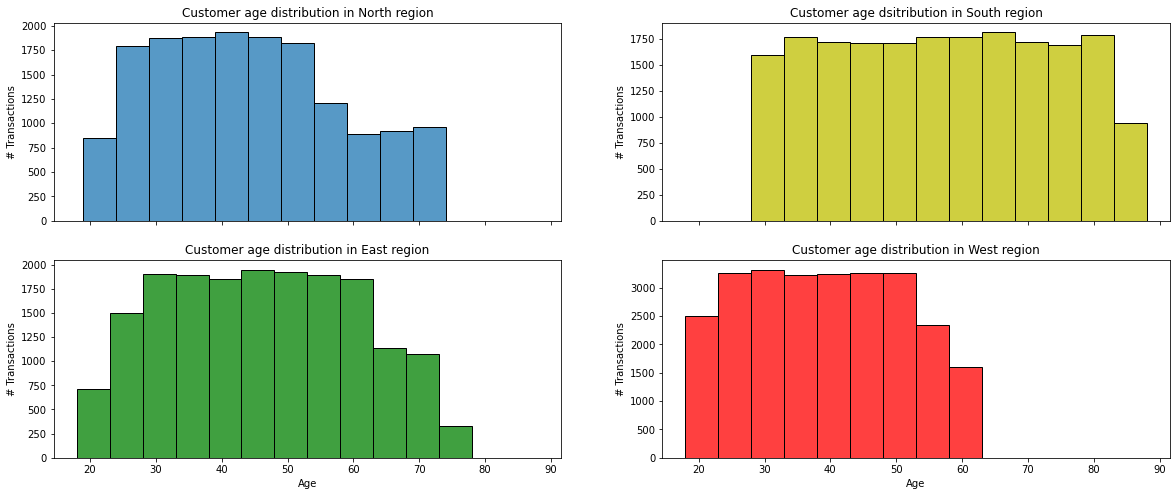

In [24]:
#Plot histograms of customers' age at each region
fig , axes = plt.subplots(2,2,figsize = (20,8), sharex=True)
sns.histplot(x="age",data=data.groupby('region').get_group(1),ax=axes[0][0],binwidth = 5)
axes[0][0].title.set_text("Customer age distribution in North region")
axes[0][0].set_xlabel('Age')
axes[0][0].set_ylabel('# Transactions')
sns.histplot(x="age",data=data.groupby('region').get_group(2),ax=axes[0][1],binwidth = 5, color = 'y')
axes[0][1].title.set_text("Customer age dsitribution in South region")
axes[0][1].set_xlabel('Age')
axes[0][1].set_ylabel('# Transactions')
sns.histplot(x="age",data=data.groupby('region').get_group(3),ax=axes[1][0],binwidth = 5, color = 'g')
axes[1][0].title.set_text("Customer age distribution in East region")
axes[1][0].set_xlabel('Age')
axes[1][0].set_ylabel('# Transactions')
sns.histplot(x="age",data=data.groupby('region').get_group(4),ax=axes[1][1],binwidth = 5, color = 'r')
axes[1][1].title.set_text("Customer age distribution in West region")
axes[1][1].set_xlabel('Age')
axes[1][1].set_ylabel('# Transactions')

<i>Figures 13-16. Histogram showing the distrubution of the customers' age in each region.</i>

There are some differences in the age demography between regions:
<ul>
    <li>In general, the number of customers between 18 and 25 years is sensibly smaller than the quantity of middle-aged clients in all regions except for the West. This is specially noticeable in the South which have no clients of this age range at all.</li>
    <li>The core of the clients is middle-aged, which is common in most businesses.</li>
    <li>In older age ranges, the North and the West start losing clients when the age approaches 55, while the East maintains the same quantity until the 60 years. The South is the only region with as many older clients as middle-aged ones, even having a small number of clients older than 80.</li>
</ul>
This observations can be applied to the objective of trying to predict age from region: since middle-aged customers have similar densities in all four regions, they might be either difficult to predict or most of the predictions may be directed to that group depending on the model used. The most useful option would be the first one, as young and people have a better margin of improvement as customers, so predicting those and directing there the marketing efforts could help improve the company's revenue.

<b>Are there differences in the age of customers between regions?</b><br>
Although in there are little to no differences regarding the amount of midddle-aged customers, there are exist some differences in the amount of younger and older customers taht could be useful for the advertisement process.

After that, the method of purchase is studied. A first approach will be to check the density of clients of each age for transactions of each kind

Text(0.5, 1.0, 'Density of in-store and on-line transactions by age')

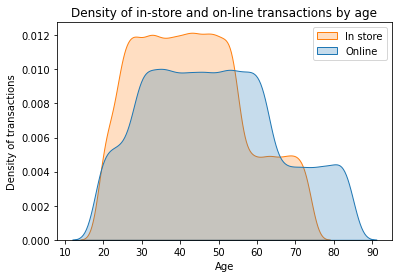

In [25]:
plot = sns.kdeplot(data = data, x= 'age', hue = 'in-store',shade = True)
plot.set_xlabel('Age')
plot.set_ylabel('Density of transactions')
plot.legend(['In store','Online'])
plot.set_title('Density of in-store and on-line transactions by age')

<i>Figure 17. Density plot showing the distribution of transactions by age for online and in-store purchases</i>

As it can be seen, the number of in-store transactions is higher for young middle-aged customers. However, the difference decreases as the age increases, with online purchases becoming the dominant method at around 52 years old. <br>
To better visualize these differents, the data can be grouped into age groups

In [26]:
#Create age group entry
less_37 = (data['age']<=37).apply(int)
btw_38_52 = ((data['age']>37) & (data['age']<=52)).apply(int)*2
more_52 = (data['age'] > 52).apply(int)*3
age_range = less_37 + btw_38_52 + more_52
data = data.join(age_range.rename('age group'))

Text(0.5, 1.0, 'Number of transaction in-store and on-line by age group')

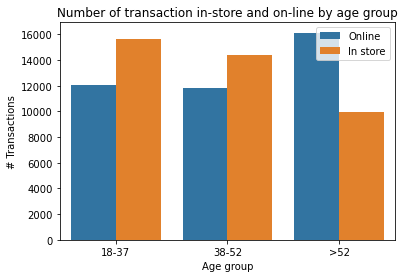

In [27]:
#Plot number of transactions online and in-store for each age group
plot = sns.countplot(data=data,x='age group', hue = 'in-store')
plot.set_xticklabels(['18-37','38-52','>52'])
plot.set_xlabel('Age group')
plot.set_ylabel('# Transactions')
plot.legend(['Online','In store'])
plot.set_title('Number of transaction in-store and on-line by age group')

<i>Figure 18. Bar plot showing the amount of transactions online and in physical stores by age group.</i>

As we showed earlier, when the age of the customers increases, the online purchases increase while the sales in stores go down. This results fit with previous observations, shuch as the South region, which has the biggest number of older consumers only having online transactions.

<b>Is there any correlation between the age of a customer and if the transaction was made online or in the store?</b><br>
Yes, although not the one expected by Mr. Goodrich. Older customers prefer buying online while young people have a greater tendency to buy in physical stores.

Lastly, the relationship between the amount spent and the age of the customers will be studied. This analysis also allows to check aonther one of Mr. Goodrich hypothesis which states that older people spend more money in electronics than younger people. Since customers have ages ranging from 18 to 85 years, in order to make this task more manageable and to take advantage from the last analysis, the age groups previously created will be used.

Text(0.5, 1.0, 'Histogram of amount spent by customers of more than 52 years')

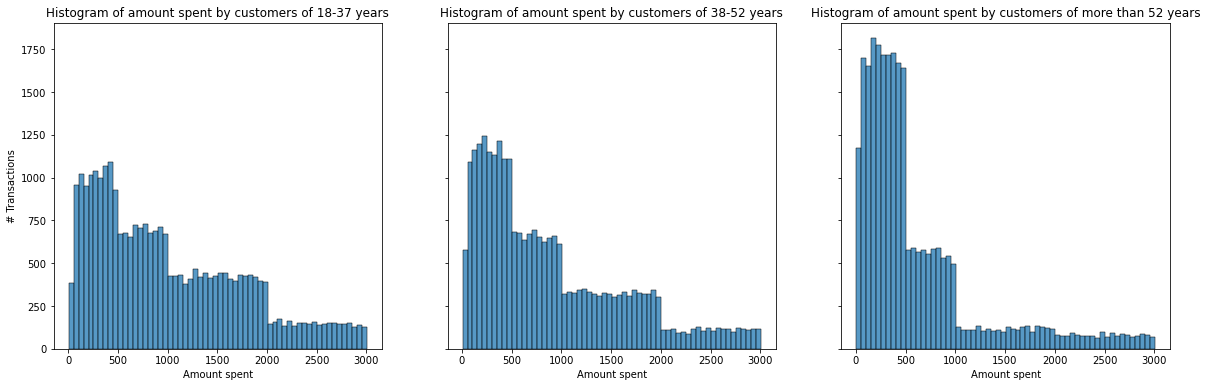

In [28]:
#Plot histograms of amount spent at each age group
plot, axes = plt.subplots(1,3,sharex = True, sharey = True,figsize = (20,6))
sns.histplot(data=data.groupby('age group').get_group(1), x = 'amount',binwidth = 50, ax = axes[0])
axes[0].set_xlabel('Amount spent')
axes[0].set_ylabel('# Transactions')
axes[0].set_title('Histogram of amount spent by customers of 18-37 years')
sns.histplot(data=data.groupby('age group').get_group(2), x = 'amount',binwidth = 50, ax = axes[1])
axes[1].set_xlabel('Amount spent')
axes[1].set_ylabel('# Transactions')
axes[1].set_title('Histogram of amount spent by customers of 38-52 years')
sns.histplot(data=data.groupby('age group').get_group(3), x = 'amount',binwidth = 50, ax = axes[2])
axes[2].set_xlabel('Amount spent')
axes[2].set_ylabel('# Transactions')
axes[2].set_title('Histogram of amount spent by customers of more than 52 years')

<i>Figures 19-21. Histograms showing the distribution of the amount spent by each age group.</i>

It is noticeable in the above graphics that the oldest age group has a lower amount of transactions in the middle-priced amounts, specially in the range 1000-2000 with an smaller difference in the 500-1000 range, while having more transactions of low amount. This is even more remarkable if the plots are compared with figure 8, which shows the distribution of the amount per transaction of the whole data set. The first two groups are distributed similarly to the sample as a whole while the oldest group has less transaction of intermediate prices, having most transaction concentrated in the 0-500 range.

From this information, it could be thought that Mr. Goodrich was wrong and older customers spent less than younger customers in the sense that their purchases are more concentrated around lower amounts of money. However, although that is a valid answer, to fully analyse this question it would be wise to also check both the total and the mean amount of money spent by each age group.

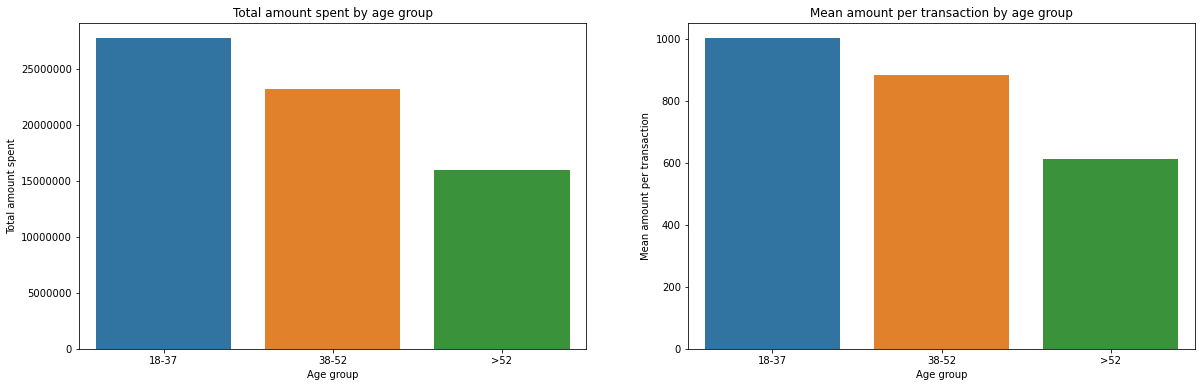

In [29]:
#Plot total and mean amount spent by each age group
plot, axes = plt.subplots(1,2,sharex = True,figsize = (20,6))
sns.barplot(x = 'age group', y = 'amount',data = data.groupby('age group').sum().reset_index(),ax = axes[0])
axes[0].set_xticklabels(['18-37','38-52','>52'])
axes[0].set_title("Total amount spent by age group")
axes[0].set_xlabel('Age group')
axes[0].set_ylabel('Total amount spent')
axes[0].ticklabel_format(style='plain', axis='y')
sns.barplot(x = 'age group', y = 'amount',data = data.groupby('age group').mean().reset_index(),ax = axes[1])
axes[1].set_xticklabels(['18-37','38-52','>52'])
axes[1].set_title("Mean amount per transaction by age group")
axes[1].set_xlabel('Age group')
axes[1].set_ylabel('Mean amount per transaction')
axes[1].ticklabel_format(style='plain', axis='y')

<i>Figures 22 and 23. Barplots showing the total spent amount and the mean price of transaction for each age group</i>

The graphics above completely disproves Mr. Goodrich's hypothesis. Older customers not only are not the group that spends the most but is the one spending the least, both in absolute terms and in average. Since young people are the biggest spenders increasing sales from that age group could be beneficial.

### Additional analysis on the purchase method

Throughout the analysis of the data that has been done until now, some insights regarding the differences between purchases done online and in physical stores have been gained. To complete this anlaysis, the difference in the amount spent with each method will be studied.<br>
For this purpose, the first step will be to check the distribution of the amount spent in transaction of each method.

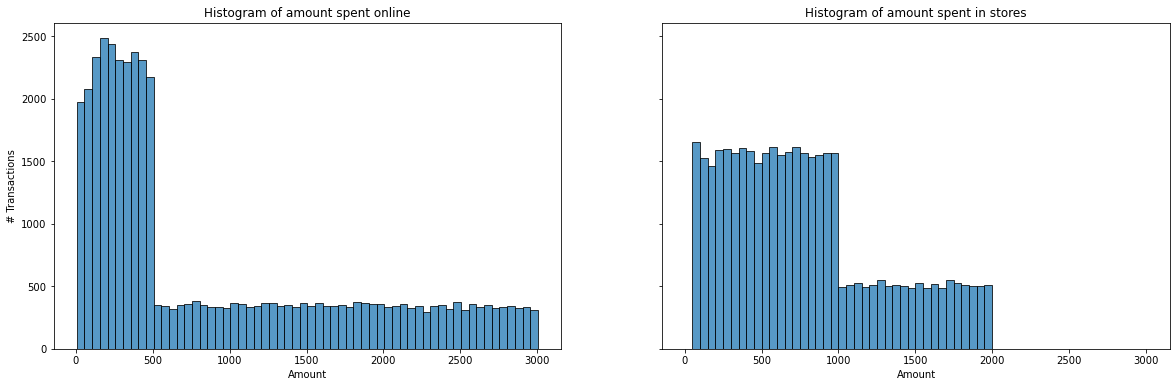

In [30]:
plot, axes = plt.subplots(1,2,sharex = True, sharey = True,figsize = (20,6))
sns.histplot(x="amount",data=data.groupby('in-store').get_group(0),ax = axes[0],binwidth = 50)
axes[0].set_title("Histogram of amount spent online")
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('# Transactions')
axes[0].ticklabel_format(style='plain', axis='y')
sns.histplot(x="amount",data=data.groupby('in-store').get_group(1),ax = axes[1],binwidth = 50)
axes[1].set_title("Histogram of amount spent in stores")
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('# Transactions')
axes[1].ticklabel_format(style='plain', axis='y')

<i>Figures 24 and 25. Histograms showing the distribution of the amount spent online and in physical stores.</i>

The graphics above shows that online purchases have a higher concentration of cheaper transactions (0-500) than those done in store, but also some purchases of higher amounts (2000-2500) which are non-existent in physical stores. In-store purchases, on the other hand, have sensibly more transactions in the range of 500-100 and also surpass by a lower amount the number of purchases of amounts between 1000 and 2000.<br>
Given this distribution, it would be useful to study the amount spent in absolute terms in order to determine how the customers spend the most.

Text(0.5, 1.0, 'Total amount spent with each purchase method')

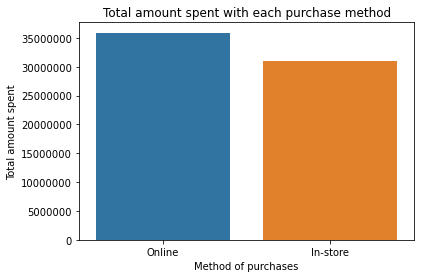

In [31]:
plot = sns.barplot(data = data.groupby('in-store').sum().reset_index(),x='in-store',y='amount')
plot.ticklabel_format(style='plain',axis = 'y')
plot.set_xlabel('Method of purchases')
plot.set_ylabel('Total amount spent')
plot.set_xticklabels(['Online','In-store'])
plot.set_title('Total amount spent with each purchase method')

<i>Figure 26. Barplot showing the total amount spent with each purchase method</i>

As it can be seen, in total customers spent more money in online purchases than in physical stores. With this information, most of the relevant information regarding the data has been gathered so, the modelling process can be started.

## Modelling

After the exploratory analysis, machine learning techniques to try to predict the <b>age</b> and the <b>method of purchase</b> of the customers from other data, using as a guide the information obtained in the previous analysis performed on the dataset. This models, apart from giving some information regarding the questions that were asked, if succesful may help Blackwell Elecetronics to predict information of the customers and adapt their advertising methods accordingly.<br>
The modelling will be done in two steps: model selection and testing

### Model selection

This section is dedicated to the process of evaluating and selecting the best model to predict the data needed. Various feature engineering process will be followed to try to find a good model for each of the cases. The modelling algorithms used will be Decision Trees and other techniques based on them such as Random Forest Classfiers and Gradient Boosting Classifiers

#### Age modelling

From the exploratory analysis it is known that although there exist some variations, all regions have most of their clients concentrated in the middle-aged range and differences exist mostly in the number of younger and older customers, which makes age a difficult variable to predict. Although other data such as the age and the method of purchase do provide more information predicting age accurately is a difficult task.

In [32]:
x = data[['in-store','items','amount','North','South','East','West']]
y = data['age']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = .25, random_state = 42)

The first step for creating a model is splitting the data into dependant and independant variable and select training and testing blocks so the model can be succesfully created and evaluated.<br>
Now that this has been done, a simple cross validation of three basic models can be done to check the initial precision, yielding the following results:

In [33]:
algos_Class = []
algos_Class.append(('Random Forest Classifier', RandomForestClassifier()))
algos_Class.append(('Decision Tree Classifier', DecisionTreeClassifier()))
algos_Class.append(('Gradient Boosting Classifier', GradientBoostingClassifier(n_estimators = 20)))
#Estimators lowered to allow a reasonable execution time
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, x_train,y_train, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classifier 0.0212
Decision Tree Classifier 0.0207
Gradient Boosting Classifier 0.022150000000000003


As it can be seen, the accuracy of this models is around 2% which is low. This makes sense, as the age of the customers ranges from 18 to 85 years, so predicting the exact value is a difficult task, for this reason feature engineering is needed to improve the model. In this case, the best way of increasing the accuracy is binning the age variable. This means dividing it into different age groups and try to predict the group to which the customer belongs rather than the exact age. This means losing precision on our results if they are correct but helps to have a better accuracy as a trade-off. Still knowing the approximate age of a customer could be helpful even if it is not exact.<br>
Even though the age has already been discretized before, this age groups will be substituted by other ones that better fits the predictions. In this case 3 groups have been chosen: young (less than 27 years), middle-aged (between 28 and 60 years) and old (older than 60 years) customers.<br>
Adjusting the parameters of the models also help to find the best one. In this case three classifiers (Random Forest, Decission Tree and Gradient Boosting) will be used. In the case of Random Forest and Decision Tree classifiers, which are not very resilient to overfitting, some hypertuning is applied to check their performance with different depths.

In [34]:
less_27 = (data['age']<=27).apply(int)
btw_28_55 = ((data['age']>27) & (data['age']<=60)).apply(int)*2
more_55 = (data['age'] > 60).apply(int)*3
age_range = less_37 + btw_38_52 + more_52
data = data.join(age_range.rename('age group 2'))

In [35]:
x = data[['in-store','items','amount','North','South','East','West','average']]
y = data['age group 2']
x_train,x_test_age,y_train,y_test_age = train_test_split(x,y,test_size = .25, random_state = 42)
algos_Class = []
algos_Class.append(('Random Forest Classifier unlimited', RandomForestClassifier()))
algos_Class.append(('Random Forest Classifier height 10', RandomForestClassifier(max_depth = 10)))
algos_Class.append(('Random Forest Classifier height 5', RandomForestClassifier(max_depth = 5)))
algos_Class.append(('Decision Tree Classifier unlimited', DecisionTreeClassifier()))
algos_Class.append(('Decision Tree Classifier height 10', DecisionTreeClassifier(max_depth = 10)))
algos_Class.append(('Decision Tree Classifier height 5', DecisionTreeClassifier(max_depth = 5)))
algos_Class.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, x_train,y_train, cv=7, scoring='accuracy')
    names.append(name)
    results.append(result)
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classifier unlimited 0.38641649379093623
Random Forest Classifier height 10 0.46531670182824747
Random Forest Classifier height 5 0.4686832315639736
Decision Tree Classifier unlimited 0.38608323517746895
Decision Tree Classifier height 10 0.4640166582135298
Decision Tree Classifier height 5 0.46691658933545516
Gradient Boosting Classifier 0.4692332629541727


As it can be seen, the accuracy has greatly increased after the feature engineering and tuning process. In this case the one with the best accuracy is the Gradient Boosting Classifier, with a precission of 46.92%, so this will be the model chosen in this case.

In [60]:
x = data[['in-store','items','amount','North','South','East','West','average']]
y = data['age group 2']
x_train,x_test_age,y_train,y_test_age = train_test_split(x,y,test_size = .25, random_state = 42)
model_age = GradientBoostingClassifier()
model_age = model_age.fit(x_train,y_train)

After the model is chosen, it is trained with the whole training set. Later on, some tests will be performed to evaluate the final model but first the second variable to be predicted will be addressed.

#### Method of purchase modelling

Throughout the analysis done until known, some important insights regarding the method of purchase have been found. Certain aspects such as the age and the region have big relations with the magnitude to be predicted wihch apparently will make the task easier than in the previous case.

In [37]:
x = data[['age','items','amount','North','South','East','West','average']]
y = data['in-store']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = .25, random_state = 42)

As in the last section the first thing done is a sepration of variables and a split between training and testing sets. Once that initial step is done an initial cross validation is performed to study the initial accuracy

In [38]:
algos_Class = []
algos_Class.append(('Random Forest Classifier unlimited', RandomForestClassifier()))
algos_Class.append(('Random Forest Classifier height 10', RandomForestClassifier(max_depth = 10)))
algos_Class.append(('Random Forest Classifier height 5', RandomForestClassifier(max_depth = 5)))
algos_Class.append(('Decision Tree Classifier unlimited', DecisionTreeClassifier()))
algos_Class.append(('Decision Tree Classifier height 10', DecisionTreeClassifier(max_depth = 10)))
algos_Class.append(('Decision Tree Classifier height 5', DecisionTreeClassifier(max_depth = 5)))
algos_Class.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, x_train,y_train, cv=7, scoring='accuracy')
    names.append(name)
    results.append(result)
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classifier unlimited 0.8637500937109385
Random Forest Classifier height 10 0.8879834235139973
Random Forest Classifier height 5 0.8822501573826553
Decision Tree Classifier unlimited 0.8468166544895919
Decision Tree Classifier height 10 0.8876000885127472
Decision Tree Classifier height 5 0.8654333945504245
Gradient Boosting Classifier 0.8878667432360575


In this case the precission is a lot better than when predicting the age or the age group. Some feature ingeeniring could be done in order to try raising the accuracy of the models even more but if it can be done, changes are very likely to be small. One example is trying to use the age binning used in the exploratory analysis when investigating the relationship between eage and method of purchase. Trying it gives the following results:

In [39]:
x = data[['age group','items','amount','North','South','East','West','average']]
y = data['in-store']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = .25, random_state = 42)
algos_Class = []
algos_Class.append(('Random Forest Classifier unlimited', RandomForestClassifier()))
algos_Class.append(('Random Forest Classifier height 10', RandomForestClassifier(max_depth = 10)))
algos_Class.append(('Random Forest Classifier height 5', RandomForestClassifier(max_depth = 5)))
algos_Class.append(('Decision Tree Classifier unlimited', DecisionTreeClassifier()))
algos_Class.append(('Decision Tree Classifier height 10', DecisionTreeClassifier(max_depth = 10)))
algos_Class.append(('Decision Tree Classifier height 5', DecisionTreeClassifier(max_depth = 5)))
algos_Class.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, x_train,y_train, cv=7, scoring='accuracy')
    names.append(name)
    results.append(result)
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classifier unlimited 0.8370999627909536
Random Forest Classifier height 10 0.8792167170965486
Random Forest Classifier height 5 0.8747666909710394
Decision Tree Classifier unlimited 0.8351166975054305
Decision Tree Classifier height 10 0.8778167209807061
Decision Tree Classifier height 5 0.8654333945504245
Gradient Boosting Classifier 0.8791500529296179


As it can be seen, the results using this discretization are very similar to the original ones and slightly lower, which makes sense, as higher precission in the independant variables is normally useful. Although some more hypertuning of the models could be tried, the changes are not significant enough to compensate for the time increase in modelling.<br>
For these reason, the original variables will be used, and the model chosen will be a Random Forest Classifier with max depth of 10, which provides an apporximate accuracy of 88.79%<br>
As done previously, now that the model is selected, it will be trained on the data.

In [52]:
x = data[['age','items','amount','North','South','East','West','average']]
y = data['in-store']
x_train,x_test_method,y_train,y_test_method = train_test_split(x,y,test_size = .25, random_state = 42)
model_method = RandomForestClassifier(max_depth = 10)
model_method = model_method.fit(x_train,y_train)

### Testing and evaluation

After all the models have been created, they will be tested with the test set selected previously and evaluated to check their real performance through a variety of metrics.

#### Age modelling

The first step to evaluate or model is to print a classification report, which provides various metrics related to the predictions to check the performance of the model.

In [61]:
preds_age = model_age.predict(x_test_age)
print(classification_report(y_test_age, preds_age))

              precision    recall  f1-score   support

           1       0.46      0.69      0.55      6955
           2       0.34      0.08      0.13      6550
           3       0.51      0.63      0.56      6495

    accuracy                           0.47     20000
   macro avg       0.43      0.46      0.41     20000
weighted avg       0.44      0.47      0.42     20000



From the table above, it is known that the f1-score of the whole model, which is a balanced measurement of the performance of the model is 47% which is approaximately the accuracy obtained in the cross-validation. Now, one important metric to check in the table is the recall. The recall is the fraction of customers belonging to an age group that are correctly predicted to be in the group. Taking a look at the table, it can be seen that groups 1 and 3 (young and old customers) have a recall of around 65% while group 2 (middle-aged customers) only has an 8% recall. This means that the model is quite good at identifying young and old clients, but has more problems with middle-aged customers.<br>
These results fit with the exploratory analysis, as middle aged-customers have very little distinguishable factors. Although this could make the model appear useless, it is important to know that young and old clients are the age groups with the lowest number of clients in various regions, and thus the ones with biggest growth potential, so identifying them could still be useful when designing a marketing campaign.<br>
Finally, something important to know is how much better the model is compared to just choosing an answer randomly, and to know this we use the Cohen Kappa Score:

In [42]:
print('The Cohen Kappa score is ',cohen_kappa_score(y_test_age,preds))

The Cohen Kappa score is  0.1989345573199014


This means that the model is around a 20% better than just choosing at random an age group. This score is not a great result but given knowledge obtained in the analysis and the peculiarites of the model it would be impossible to obtain a significantly better result with the current data set. Still, as explained above, the model can still be useful to the company if used properly.

<b>Can we predict the age of a customer in a region based on other demographic data?</b><br>
Although the the age cannot be determined precisely, the age groups corresponding to young and old customers can be identified with a sufficently high precision.

#### Method of purchase modelling

As in the previous case, the first thing to do in order to evaluate the model is printing the evaluation matrix.

In [53]:
preds_method = model_method.predict(x_test_method)
print(classification_report(y_test_method,preds_method))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87     10045
           1       0.81      1.00      0.90      9955

    accuracy                           0.89     20000
   macro avg       0.91      0.89      0.88     20000
weighted avg       0.91      0.89      0.88     20000



In this case, the results are a lot better than in the previous case. Taking a look at the values it can be known that all the in-store purchases were identified as such (recall of 1) and all the transactions predicted to be done online were correct (precision of 1), this makes a model that over all predicts correctly the method of purchase around 90% of the time, which can be very usfeul to Blackwell Electronics when designing their marketing campaign.<br>
As with the age modelling, it is important to check the Cohen Kappa Score to compare our results with a random selection:

In [64]:
print('The Cohen Kappa score is ',cohen_kappa_score(y_test_method,preds_method))

The Cohen Kappa score is  0.7711313175773246


This time the score is a lot higher, reaching a value of around 77%, which means that the model is a lot better than a random classifier.

<b>Do other factors correlate to an online or in-store transaction?</b><br>
Yes, there are many factors that correlate to online and in-store transactions, and with them a model can be created that predicts the purchase method with around a 90% accuracy.

## Conclusions

After the analysis performed, the insights obtained about the data set can be sumed up in the following points:
<ul>
    <li><b><b>Task 1:</b></b></li>
<ul>
    <li><b>Do customers in different regions spend more per transaction?</b></li>
    Yes, customers in the West region tend to spend the most followed by the East and the North, with South being the region expending the least. The main difference between the West and the rest of the regions is a high number of purchases in a price range of 1000 to 2000, with the rest of the regions having a fewer number of transactions or none in that range. Increasing the sales of amounts in these range of prices in other regions could be a way of improving the profits there. The South is the least spender by far due to its purchases being concentrated only in a cheap range.
    <li><b>Which regions spend the most/least?</b></li>
    Again, the West is the biggest spender by a wide difference, followed by the East and the North, with the South being at the tail. This behaviour can be explained by the same causes as the previous question.
    <li><b>Is there a relationship between number of items purchased and amount spent?</b></li>
    No, there is no relation between the number of items purchased and the amount spent. For any number of items purchased, the amount spent in the transaction is equally distributed. This comes from the fact that transactions with higher number of items tend to contain products of lower value. A possible explanation for this behaviour could come from the fact that electronic stores sell a big range of products, from high priced devices to cheaper products like accessories and orders with many items could come from accessories sales while transactions with fewer products would refer to orders of products of higher value.
</ul>
<li><b><b>Task 2:</b></b></li>
<ul>
    <li><b>Are there differences in the age of customers between regions?</b></li>
    Although the main group of customers is between 30 and 55 years old in all regions, there exist small differences in the distribution of the customers' age between regions.<br>
    The West has the highest amount of young customers (18-25 years old), while other regions having less customers of that ages and the South region having none at all. Regarding older customers, the North and the West start losing customers around the 53 years, while the East maintains the same quantity until the 60 years. The South is the only region with as many older clients as middle-aged ones, even having a small number of clients older than 80. <br>
    <li><b>If so, can we predict the age of a customer in a region based on other demographic data?</b></li>
    The differences regarding the age of customers are not significant enough to be able to predict the age with precision, even when binning into age groups. Still, it is possible to correctly identify about 65% of the young (less than 27 years old) and old (more than 60 years old) customers, which could still be useful when preparing a marketing campaign.
    <li><b>Is there any correlation between age of a customer and if the transaction was made online or in the store?</b></li>
    Yes, younger age groups tend to buy more in physical stores while older groups prefer online purchases. This fits with other observations, like the South region having only online purchases and the highest number of old clients.<br>
    <li><b>Do other factors correlate to an online or in-store transaction?</b></li>
    Yes, there are noticeable differences in the way the purchases are done in each region. The most remarkable one is the South region only having online purchases and the clients from the North only buying in physical stores. These behaviours could be explained with South region not having physical stores and the online services being unavailable in the North. Giving access to these services in the corresponding regions could increase the profits obtained from them.<br>
    Also, online purchases have a higher concentration of cheaper transactions (0-500) than those done in store, but also some purchases of higher amounts (2000-2500) which are non-existent in physical stores. In-store purchases, on the other hand, have sensibly more transactions in the range of 500-100 and also surpass by a lower amount the number of purchases of amounts between 1000 and 2000.<br>
    All these differences allow to create an effective model which can correctly determine the method of purchase around with a precision of around 90%
</ul>
    <li><b><b>Additional observations:</b></b></li>
<ul>
    <li><b>Decimal places</b></li>
As explained in the pre-processing, there exist some values of the amount spent in each order that are stored with more than two decimal places. In general, all values have been checked to have 5 significant digits, which probably comes from the software used to gather the data. As mentioned previously, a possible cause for the abnormal decimals could be that the values are stored before applying VAT.
</ul>
</ul>